In [1]:
import path_setup
import scipy.io as spio
import mat73
import scipy.io.matlab as spiomat
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import matplotlib
from sklearn.model_selection import train_test_split
from blind_localization.data.datasets import *
from blind_localization.models.contrastive import *
from blind_localization.models.contrastive_pipeline import *
from blind_localization.models.decoder import *
from blind_localization.visualize import *
from tqdm import tqdm
import wandb
import pickle
from script.utils import save_if_better
from sklearn.linear_model import LogisticRegression

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(parent_dir)

### Helper Function

In [4]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    try:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        return _check_keys(data)
    except:
        return mat73.loadmat(filename)

In [5]:
class DotDict(dict):
    # def __getattr__(self, name):
    #     return self[name]
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value
    
    def __repr__(self) -> str:
        return str(list(self.keys()))
    
    def __getstate__(self):
        # Return what you want to pickle
        return self.__dict__

    def __setstate__(self, state):
        # Restore state from the unpickled state
        self.__dict__.update(state)
    

def loadmat_full(filename,structname=None):
    if structname is None:
        mat = loadmat(filename)
    else:
        mat = loadmat(filename)[structname]
    mat = DotDict(mat)
    return mat

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        # if isinstance(dict[key], spiomat.mio5_params.mat_struct):
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
        
        elif isinstance(dict[key], np.ndarray):
            
            dict_key_res = np.zeros_like(dict[key])
            # with np.nditer([dict[key],dict_key_res],op_flags=[['readonly'], ['readwrite']]) as it:
            for ind,x in np.ndenumerate(dict_key_res): 
                orig_val = dict[key][ind]
                
                if isinstance(orig_val,scipy.io.matlab.mat_struct):
                    dict_key_res[ind] = _todict(orig_val)
                else:
                    dict_key_res[ind] = orig_val

            dict[key] = dict_key_res
        
    return dict

In [6]:
def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        # if isinstance(elem, spiomat.mio5_params.mat_struct):
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray) and len(elem) >= 1: # used for the multi maze case; then there might be a cell array of struct that is not correctly unwrapped
            # if isinstance(elem[0], spiomat.mio5_params.mat_struct):
            if isinstance(elem, scipy.io.matlab.mat_struct):
                dict[strg] = np.array([_todict(e) for e in elem],dtype=object)
            else:
                dict[strg] = elem
        else:
            dict[strg] = elem
    return dict

### 1. Load Raw Waveform

In [7]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
session_names = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01', 'NN_syn_02']
waveforms_all = []
class_labels_selected_all = []  # class_labels of channels with maxWaveform assigned to it
class_labels_all = []
maxWaveformCh_all = []
channel_channel_maps = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.spikes.cellinfo.mat"
    mat = loadmat_full(file_path, structname='spikes')

    # find channel_channel_map to fix channel
    source_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", session_names[i])
    public_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", "public")
    
    raw_signal, df, skipped_channels = load_data(source_file["raw_signal_path"], public_file["label_path"], source_file["xml_path"], sheet_name=source_file["sheet_name"],
                                                 sample_rate=20000, T=30)
    channel_region_map, skipped_channels, channel_channel_map = process_labels(df, public_file["mapping_path"], skipped_channels)
    raw_signal = process_signals(raw_signal, channel_channel_map)

    # load raw signal and raw waveform
    raw_signal, class_labels, swr_timestamp = load_signal_labels(session_names[i])
    
    raw_waveforms = np.vstack(mat['rawWaveform'])
    maxWaveformCh = np.array([channel_channel_map[maxCh] for maxCh in mat['maxWaveformCh']])
    class_label_selected = class_labels[maxWaveformCh]

    waveforms_all.append(raw_waveforms[class_label_selected != 5])
    class_labels_selected_all.append(class_label_selected[class_label_selected != 5])
    maxWaveformCh_all.append(maxWaveformCh[class_label_selected != 5])
    class_labels_all.append(class_labels)
    channel_channel_maps.append(channel_channel_map)

100%|██████████| 1024/1024 [00:02<00:00, 371.61it/s]


In [8]:
color_names = ["red", "orange", "green", "blue", "magenta", "black"]
colors_all = [[color_names[c] for c in class_labels] for class_labels in class_labels_selected_all]

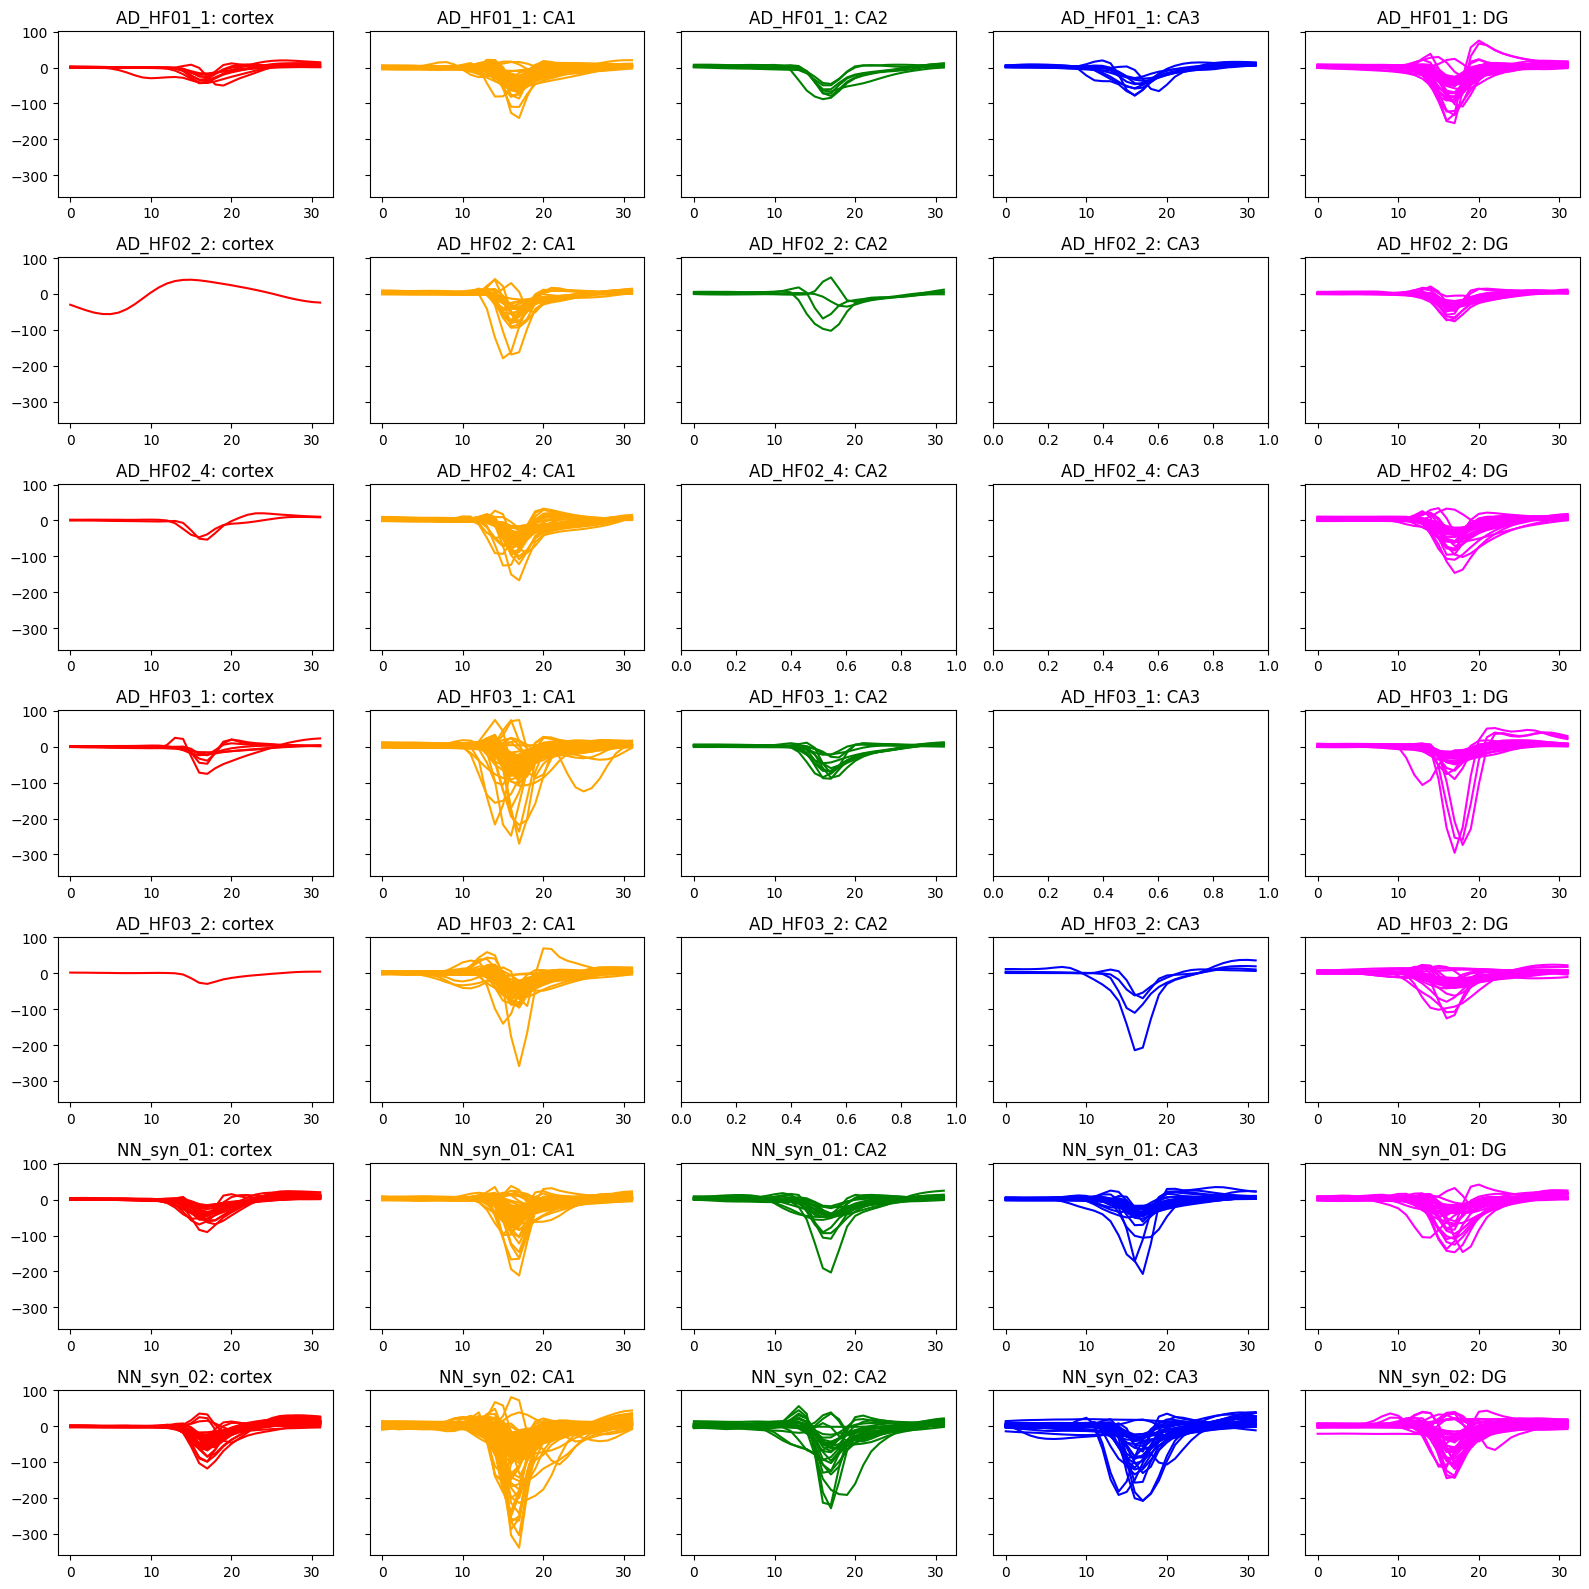

In [9]:
# normalize by the channels in std
fig, axes = plt.subplots(len(sessions), len(color_names)-1, figsize=(16, 16), sharey=True)
brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']

for s in range(len(session_names)):
    for color_idx, color in enumerate(color_names[:-1]):
        raw_waveforms = waveforms_all[s]
        colors = colors_all[s]
        
        for i, (wav, wav_color) in enumerate(zip(raw_waveforms, colors)):
            if wav_color == color:
                axes[s][color_idx].plot(wav, c=color)
    
        axes[s][color_idx].set_title(f"{session_names[s]}: {brain_regions[color_idx]}")

plt.tight_layout()
plt.show()

In [10]:
# for each spike time, extract the LFP signal (and spike waveforms) for that trial
# spike_times = mat['times']
# t_min, t_max = 2160, 2340
# selected_timestamp = [s[(s > t_min) & (s < t_max)] for s in spike_times]

In [11]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
channel_waveforms_all = []
goodChannels_all = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/region_decoding/data/Neuronexus/waveforms/{sessions[i]}_waveforms.mat"
    mat = loadmat_full(file_path, structname='spikesNew')
    waveform_dist = np.array(mat['avgWaveform'])

    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.session.mat"
    mat = loadmat_full(file_path, structname='session')
    badChannels = mat['channelTags']['Bad']['channels']
    badChannels = badChannels - 1
    channel_channel_map = channel_channel_maps[i]
    badChannels = np.array([channel_channel_map[int(ch)] for ch in badChannels])
        
    goodChannels = np.setdiff1d(np.arange(1024), badChannels)
    
    channel_waveforms_all.append(waveform_dist)
    goodChannels_all.append(goodChannels)

In [12]:
def visualize_channel_waveform(all_waveforms, all_channels, maxWaveformChannels=None, rows=128, cols=8, scale=100, top_n=5, n_neurons=5, percentile=80, channel_samples=4):
    fig, ax = plt.subplots()

    for n in range(n_neurons):
        waveforms = all_waveforms[n]
        channels = all_channels[::channel_samples]
        
        xs = channels // rows * scale
        ys = np.mod(channels, rows) 
    
        amplitudes = [np.max(np.abs(waveform)) for waveform in waveforms]
        top_n_amplitudes = sorted(amplitudes, reverse=True)[:top_n]
        scaling_factor = np.mean(top_n_amplitudes)
        amp_threshold = np.percentile(amplitudes, percentile)
        
        scaled_waveforms = [waveform / scaling_factor for waveform in waveforms]
        norm_amplitudes = (amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes) + 1e-8)
        
        cmap = cm.YlOrBr
        colors = cmap(norm_amplitudes)
        
        ax.scatter(xs, ys, color='gray')
        
        for i, (x, y) in enumerate(zip(xs, ys)):            
            offset_waveform = scaled_waveforms[i] *5 + y
            if amplitudes[i] > amp_threshold:
                ax.plot(np.arange(len(waveforms[i])) + x, offset_waveform, color=colors[i])

    if maxWaveformChannels is not None:
        xs = maxWaveformChannels // rows * scale
        ys = np.mod(maxWaveformChannels, rows)
        ax.scatter(xs, ys, color='blue')
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(amplitudes), vmax=np.max(amplitudes)))
    sm.set_array([])  # Required for ScalarMappable to work
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Amplitude')
            
    plt.show()

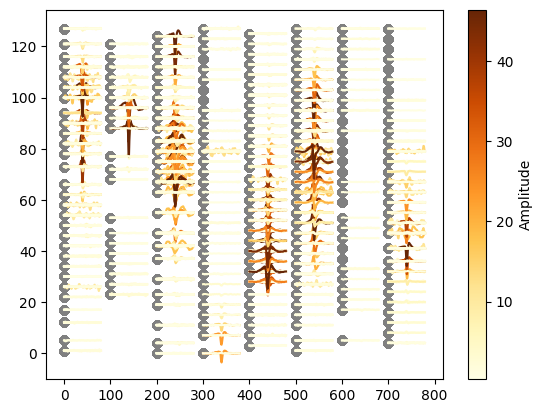

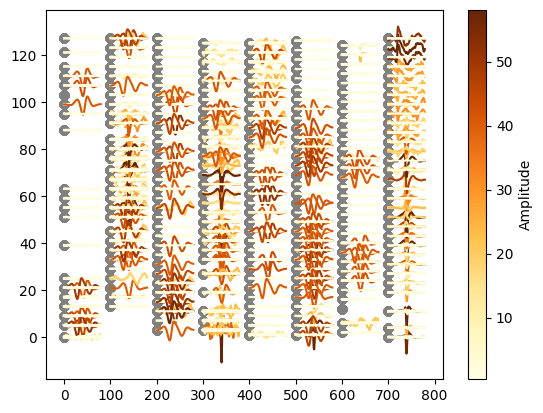

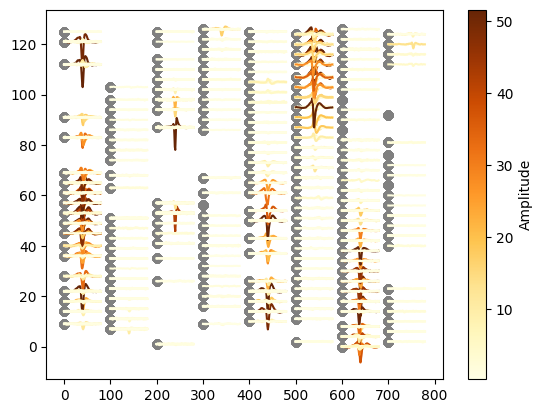

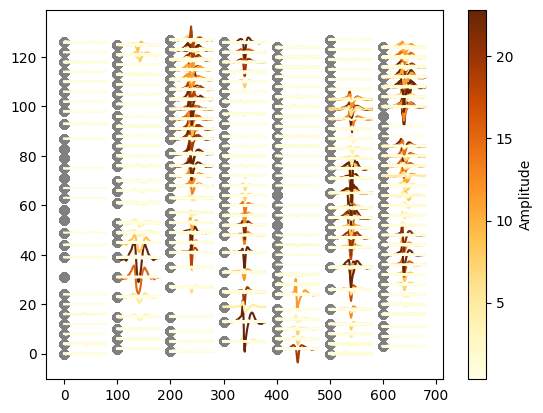

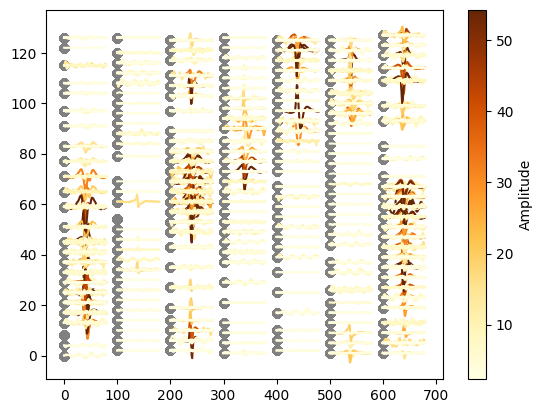

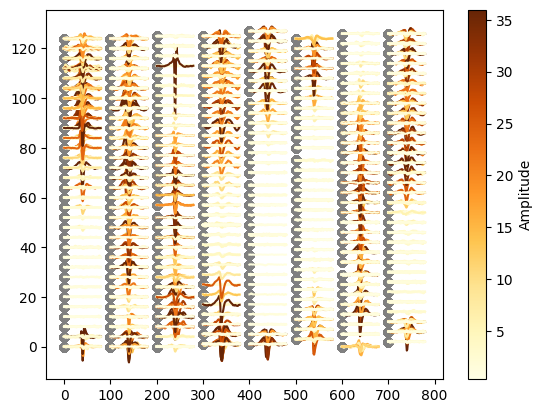

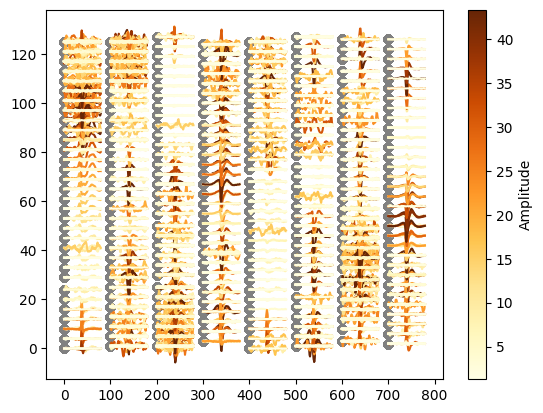

In [13]:
for i in range(len(channel_waveforms_all)):
    visualize_channel_waveform(channel_waveforms_all[i], goodChannels_all[i], n_neurons=len(channel_waveforms_all[i]), percentile=90, channel_samples=4)

### 2. Within Session Multimodal Prediction

In [14]:
pickle_path = f'/scratch/th3129/region_decoding/data/Neuronexus/lfp'
sessions = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01', 'NN_syn_02']

In [32]:
sweep_config = {
        'fc_layer_size': 512,
        'decoder_layer_size': 128,
        'encoder_epochs': 50,
        'decoder_epochs': 20,
        'patience': 7,
        'latent_size': 128,
        'spectrogram_size': 500,
        'encoder_learning_rate': 8e-5,
        'decoder_learning_rate': 5e-5,
        'batch_size': 64,
        'temperature': 0.606,
        'time_bins': 16,
        'library': 'librosa'
}

In [16]:
session_config = {
        "separate": True,
        "visualize": True,
        'swr_flag': False,
        't_starts': np.arange(2160, 2340, 3),
        'within_session': True,
        'supervised_contrastive': False,
        'sampling_rate': 1250,
        'trial_length': 3,
        'session_idx': True
    }

In [17]:
def load_preprocessed_data(pickle_path, file_path):
    features, labels, trials = {}, {}, {}
    for session in file_path:
        data = pickle.load(open(f"{pickle_path}/{session}_raw.pickle", 'rb'))
        # data = pickle.load(open(f"{pickle_path}/{session}_lfp.pickle", 'rb'))
        X, y, trial_idx = zip(*[(d[0], d[1], d[2]) for d in data])
        features[session] = np.array(X)
        labels[session] = np.array(y, dtype=int)
        trials[session] = np.array(trial_idx)

        non_zero_indices = [i for i, x in enumerate(features[session]) if not np.all(x == 0)]

        features[session] = features[session][non_zero_indices]
        labels[session] = labels[session][non_zero_indices]
        trials[session] = trials[session][non_zero_indices]

        # Sanity check
        assert len(features[session]) == len(labels[session]) == len(trials[session]), \
            f"Inconsistent data sizes for session {session}"

    return features, labels, trials

In [18]:
channel_features_all, channel_labels_all, channel_trials_all = load_preprocessed_data(pickle_path, sessions)

In [19]:
channel_static_waveforms_all = []
channel_inflated_waveforms_all = []

for i in range(len(session_names)):
    class_labels_good_channels = class_labels_all[i][goodChannels_all[i]]
    channel_waveforms = channel_waveforms_all[i].transpose(1, 0, 2)
    channel_waveforms_selected = channel_waveforms[class_labels_good_channels != 5]
    channel_waveforms_flattened = channel_waveforms_selected.reshape(channel_waveforms_selected.shape[0], -1)
    
    channel_static_waveforms_all.append(channel_waveforms_selected)
    channel_inflated_waveforms_all.append(np.repeat(channel_waveforms_flattened, 60, axis=0))

In [20]:
def build_single_session_dataloader(channel_features_all, channel_labels_all, channel_trials_all, channel_waveforms_all,
                                    config, Dataset, sessions, session_idx=0, trial_length = 60):
    features = channel_features_all.get(sessions[session_idx])
    labels = channel_labels_all.get(sessions[session_idx])
    trials = channel_trials_all.get(sessions[session_idx])
    waveforms = channel_waveforms_all[session_idx]

    train_tr_idx, test_tr_idx = train_test_split(range(trial_length), test_size=0.2, random_state=42)
    train_tr_idx, val_tr_idx = train_test_split(train_tr_idx, test_size=0.25, random_state=42)

    train_idx = sorted([idx for idx, val in enumerate(trials) if val in train_tr_idx], key=lambda idx: train_tr_idx.index(trials[idx]))
    val_idx = sorted([idx for idx, val in enumerate(trials) if val in val_tr_idx], key=lambda idx: val_tr_idx.index(trials[idx]))
    test_idx = sorted([idx for idx, val in enumerate(trials) if val in test_tr_idx], key=lambda idx: test_tr_idx.index(trials[idx]))
    
    X_train, y_train = features[train_idx], labels[train_idx]
    X_val, y_val = features[val_idx], labels[val_idx]
    X_test, y_test = features[test_idx], labels[test_idx]

    train_dataset = Dataset(np.array(X_train), y_train, waveforms[train_idx], spectrogram_size=500,
                            time_bins=config["time_bins"], library=config["library"])
    val_dataset = Dataset(np.array(X_val), y_val, waveforms[val_idx], spectrogram_size=500,
                          time_bins=config["time_bins"], library=config["library"])
    test_dataset = Dataset(np.array(X_test), y_test, waveforms[test_idx], spectrogram_size=500,
                           time_bins=config["time_bins"], library=config["library"])

    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

In [27]:
class MultiModalDataset(RawDataset):
    def __init__(self, raw_signal, labels, waveforms, spectrogram_size=500, time_bins=None, library='librosa'):
        super().__init__(raw_signal, labels, spectrogram_size=spectrogram_size, library=library, time_bins=time_bins)
        self.waveforms = torch.tensor(waveforms, dtype=torch.float32)

    def add_gaussian_noise(self, signal):
        return signal + torch.randn_like(signal) * 0.01

    def __getitem__(self, index):
        (spectrograms, augmented_spectrograms), label = super().__getitem__(index)
        waveform = self.waveforms[index]
        augmented_waveform = self.add_gaussian_noise(waveform)
        
        data = torch.cat((spectrograms, waveform), axis=0)
        augmented_data = torch.cat((augmented_spectrograms, augmented_waveform), axis=0)
        
        return (data, augmented_data), label

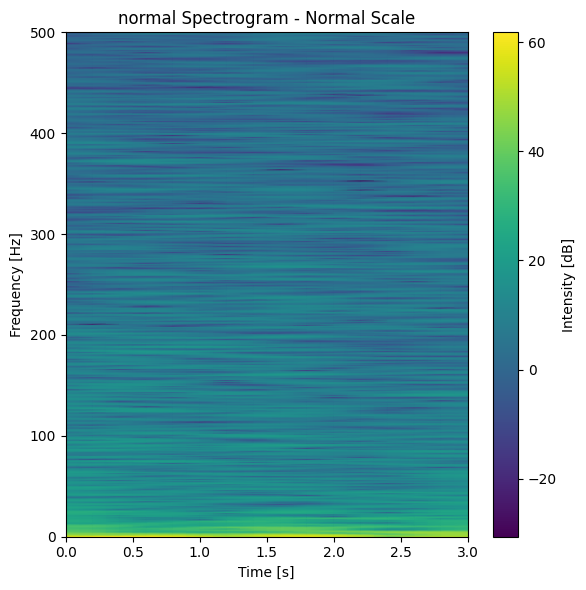

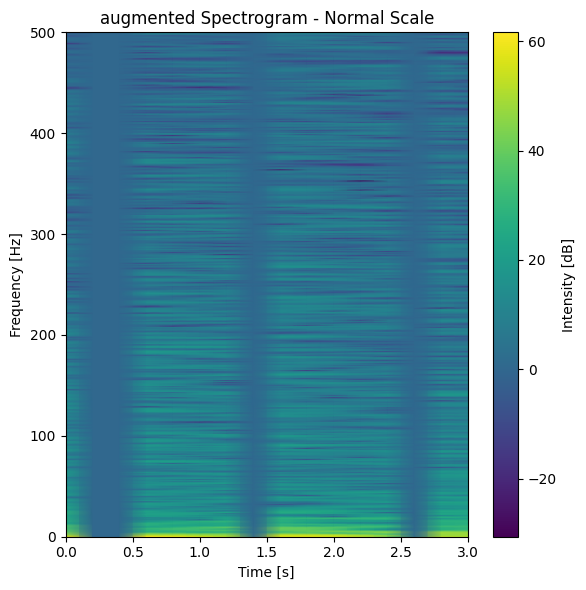

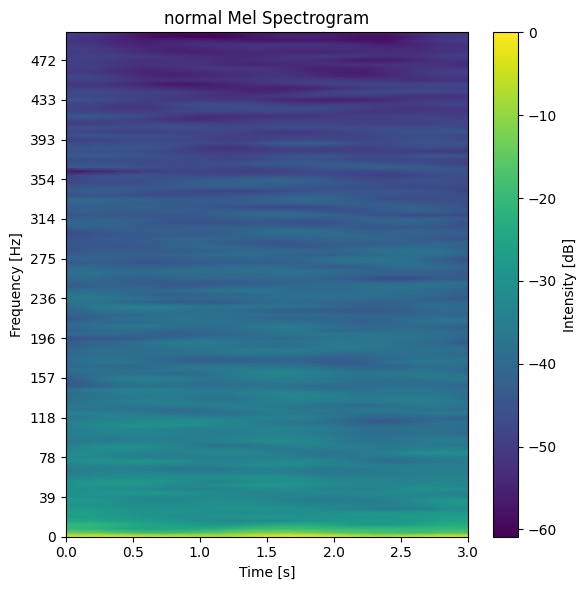

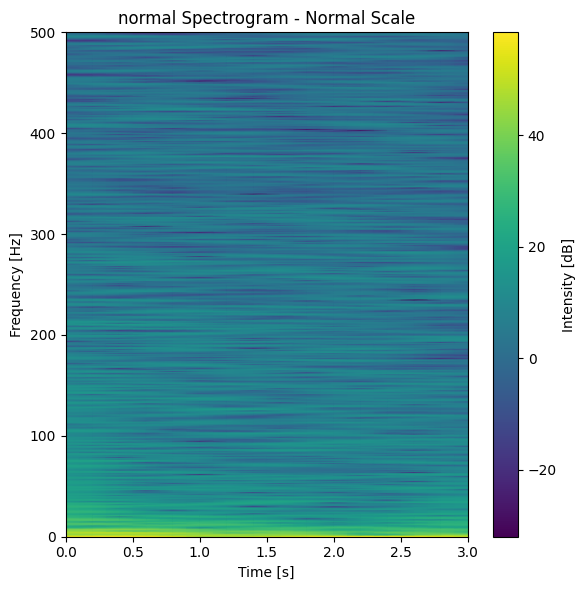

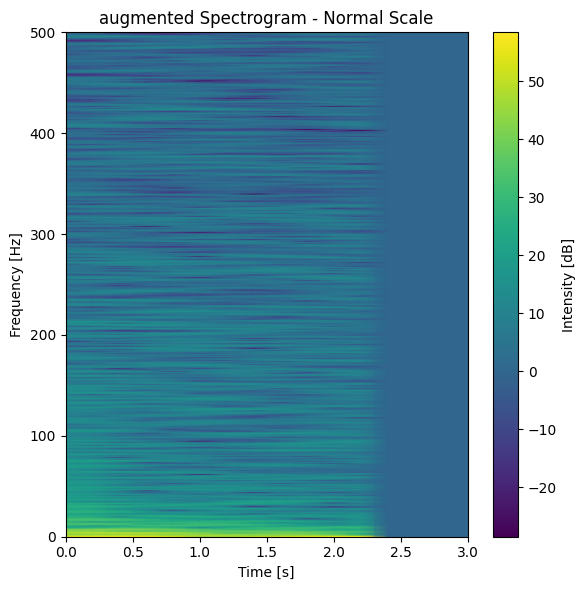

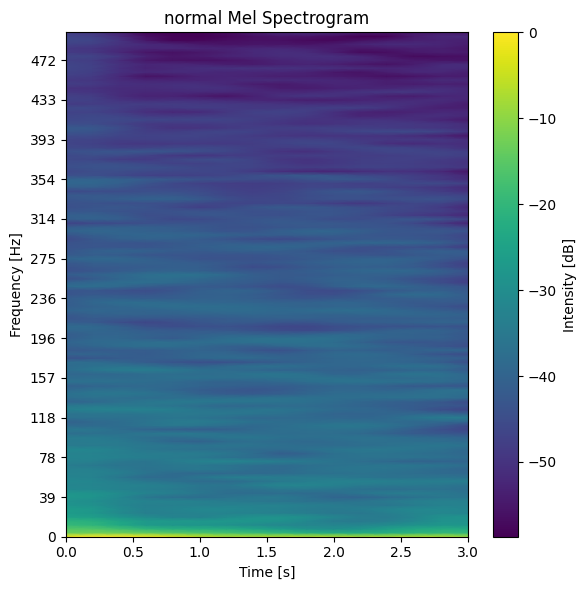

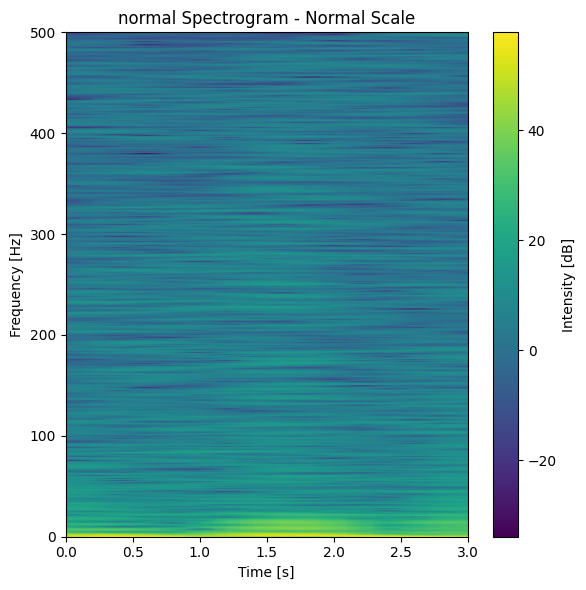

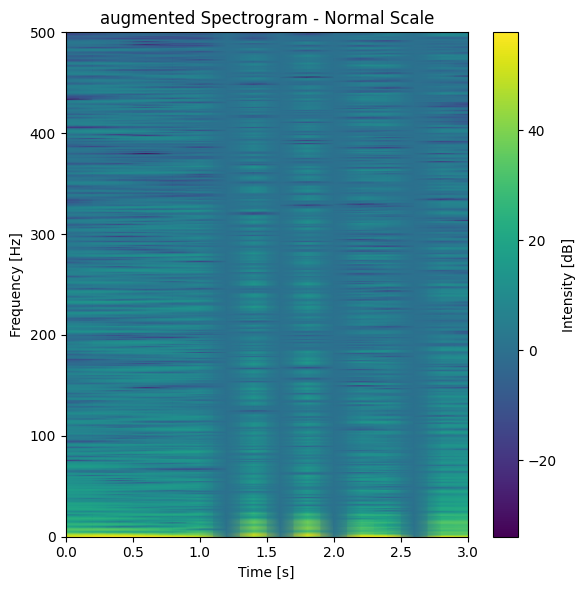

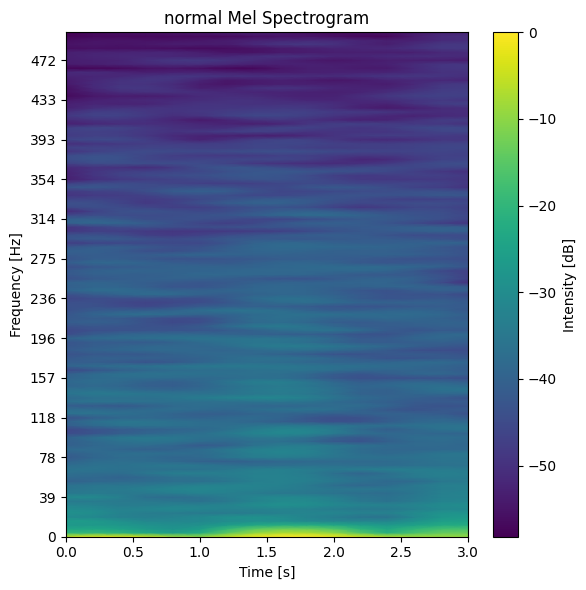

In [51]:
train_dataloader, val_dataloader, test_dataloader = build_single_session_dataloader(channel_features_all, channel_labels_all,
                                                                                    channel_trials_all, channel_inflated_waveforms_all,
                                                                                    sweep_config, MultiModalDataset, sessions, session_idx=0)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = train_dataloader.dataset[0][0][0].size()[0]
encoder = ContrastiveEncoder(sweep_config['fc_layer_size'], input_size=input_size, output_size=sweep_config['latent_size']).to(device)
model = ContrastiveLearningWithMLP(encoder, input_dim=sweep_config['latent_size'], hidden_dim=sweep_config['decoder_layer_size'], output_dim=5).to(device)

contrastive_criterion = InfoNCELoss(temperature=sweep_config['temperature'], device=device)
supervised_criterion = nn.CrossEntropyLoss()

encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=sweep_config["encoder_learning_rate"])
combined_optimizer = optim.Adam(model.parameters(), lr=sweep_config["decoder_learning_rate"])
best_decoder_loss = 10000
patience_counter = 0

In [54]:
for epoch in range(sweep_config["encoder_epochs"]):
    train_loss = train(model.encoder, train_dataloader, encoder_optimizer, contrastive_criterion, device)
    val_loss = validation(model.encoder, val_dataloader, contrastive_criterion, device)
    
    print(f'Epoch [{epoch+1}/{sweep_config["encoder_epochs"]}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/50], Train Loss: 3.7586, Val Loss: 3.5485
Epoch [2/50], Train Loss: 3.5385, Val Loss: 3.5903
Epoch [3/50], Train Loss: 3.5058, Val Loss: 3.5406
Epoch [4/50], Train Loss: 3.4691, Val Loss: 3.4356
Epoch [5/50], Train Loss: 3.4309, Val Loss: 3.4404
Epoch [6/50], Train Loss: 3.3995, Val Loss: 3.3946
Epoch [7/50], Train Loss: 3.3820, Val Loss: 3.3871
Epoch [8/50], Train Loss: 3.3691, Val Loss: 3.3882
Epoch [9/50], Train Loss: 3.3595, Val Loss: 3.3668
Epoch [10/50], Train Loss: 3.3570, Val Loss: 3.3834
Epoch [11/50], Train Loss: 3.3522, Val Loss: 3.3576
Epoch [12/50], Train Loss: 3.3386, Val Loss: 3.3508
Epoch [13/50], Train Loss: 3.3380, Val Loss: 3.3861
Epoch [14/50], Train Loss: 3.3307, Val Loss: 3.3600
Epoch [15/50], Train Loss: 3.3291, Val Loss: 3.3665
Epoch [16/50], Train Loss: 3.3284, Val Loss: 3.3487
Epoch [17/50], Train Loss: 3.3176, Val Loss: 3.3500
Epoch [18/50], Train Loss: 3.3198, Val Loss: 3.3533
Epoch [19/50], Train Loss: 3.3142, Val Loss: 3.3433
Epoch [20/50], Train 

In [ ]:
for epoch in range(sweep_config['decoder_epochs']):
    decoder_train_metrics = train_decoder(model, train_dataloader, combined_optimizer, contrastive_criterion, supervised_criterion, mode=session_config['separate'], device=device)
    decoder_val_metrics = validate_decoder(model, val_dataloader, supervised_criterion, device=device)

    if decoder_val_metrics['loss'] < best_decoder_loss:
        best_decoder_loss, patience_counter = decoder_val_metrics['loss'], 0
    else:
        patience_counter += 1
        if patience_counter >= sweep_config['patience']: break

    print(f'Epoch [{epoch+1}/{sweep_config["decoder_epochs"]}], Train Loss: {decoder_train_metrics["loss"]:.4f}, Val Loss: {decoder_val_metrics["loss"]:.4f}, Train Acc: {decoder_train_metrics["balanced_accuracy"]:.4f}, Val Acc: {decoder_val_metrics["balanced_accuracy"]:.4f}')

Epoch [1/20], Train Loss: 3.9041, Val Loss: 0.1573, Train Acc: 0.7708, Val Acc: 0.9433
Epoch [2/20], Train Loss: 3.4290, Val Loss: 0.0418, Train Acc: 0.9699, Val Acc: 0.9872
Epoch [3/20], Train Loss: 3.3566, Val Loss: 0.0252, Train Acc: 0.9948, Val Acc: 0.9959
Epoch [4/20], Train Loss: 3.3304, Val Loss: 0.0128, Train Acc: 0.9989, Val Acc: 0.9985


In [62]:
decoder_test_metrics = validate_decoder(model, test_dataloader, supervised_criterion, device=device)
print(f"target session {sessions[0]} test balanced accuracy: ", decoder_test_metrics["balanced_accuracy"],
    f"target session {sessions[0]} test f1 score: ", decoder_test_metrics["macro_f1"])

target session AD_HF01_1 test balanced accuracy:  1.0 target session AD_HF01_1 test f1 score:  1.0


### 3. Load Multi Session Waveforms

In [21]:
def cell_to_cluster(channel_features, cluster_labels):
    n_units, n_channels, n_time = channel_features.shape
    n_clusters = len(np.unique(cluster_labels))
    
    channel_features_new = np.zeros((n_clusters, n_channels, n_time))
    for c in range(n_clusters):
        cluster_indices = np.where(cluster_labels == c)[0]
        channel_features_new[c] = np.mean(channel_features[cluster_indices], axis=0)
    return channel_features_new

In [22]:
from sklearn.cluster import KMeans

def get_cluster_labels(channel_waveforms, n_clusters=5):
    n_units, n_channels, n_times = channel_waveforms.shape
    waveforms = []
    maxWaveformChannelIndex = np.argmax(np.abs(channel_waveforms).max(axis=2), axis=1)
    
    for i in range(n_units):
        waveform = channel_waveforms[i][maxWaveformChannelIndex[i]]
        waveforms.append(waveform)
    
    waveforms = np.array(waveforms)
    
    min_vals = np.min(waveforms, axis=1, keepdims=True)
    max_vals = np.max(waveforms, axis=1, keepdims=True)
    normalized_waveforms = waveforms / (max_vals - min_vals)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_waveforms)
    return cluster_labels

In [23]:
agg_channel_features_all = []
agg_channel_features_inflated_all = []

for i in range(len(channel_waveforms_all)):
    cluster_labels = get_cluster_labels(channel_waveforms_all[i], n_clusters=5)
    agg_waveforms = cell_to_cluster(channel_waveforms_all[i], cluster_labels)
    agg_waveforms = agg_waveforms.transpose(1, 0, 2).reshape(agg_waveforms.shape[1], -1)

    class_labels_good_channels = class_labels_all[i][goodChannels_all[i]]
    data = agg_waveforms[class_labels_good_channels != 5]

    agg_channel_features_all.append(data)
    agg_channel_features_inflated_all.append(np.repeat(data, 60, axis=0))

### 4. Across Session Multimodal Prediction

In [24]:
def build_multi_session_dataloader(channel_features_all, channel_labels_all, channel_trials_all, channel_waveforms_all,
                                   sessions, config, Dataset, trial_length = 60, test_session_idx=0, vit=False):
    X_test = channel_features_all.get(sessions[test_session_idx])
    y_test = channel_labels_all.get(sessions[test_session_idx])
    X_test_waveforms = channel_waveforms_all[test_session_idx]
    trials = channel_trials_all.get(sessions[test_session_idx])

    train_tr_idx, test_tr_idx = train_test_split(range(trial_length), test_size=0.2, random_state=42)
    test_idx = [idx for idx, val in enumerate(trials) if val not in train_tr_idx]

    print(X_test_waveforms.shape, X_test.shape, y_test.shape)
    X_test = [X_test[idx] for idx in test_idx]
    y_test = [y_test[idx] for idx in test_idx]
    X_test_waveforms = [X_test_waveforms[idx] for idx in test_idx]
    print(len(X_test_waveforms), len(X_test), len(y_test))

    X_train, X_train_waveforms, y_train, X_val, X_val_waveforms, y_val = [], [], [], [], [], []
    for i, sess in enumerate(sessions):
        if sess == sessions[test_session_idx]:
            continue
        features = channel_features_all.get(sess)
        labels = channel_labels_all.get(sess)
        trial_idx = channel_trials_all.get(sess)
        waveforms = channel_waveforms_all[i]
        print(features.shape, labels.shape, waveforms.shape)

        train_idx = [idx for idx, val in enumerate(trial_idx) if val in train_tr_idx]
        idx_train, idx_val = train_test_split(train_idx, test_size=0.2, random_state=42,
                                              stratify=labels[train_idx])
        X_train.extend(features[idx_train])
        X_train_waveforms.extend(waveforms[idx_train])
        y_train.extend(labels[idx_train])

        X_val.extend(features[idx_val])
        X_val_waveforms.extend(waveforms[idx_val])
        y_val.extend(labels[idx_val])

    train_dataset = Dataset(np.array(X_train), y_train, X_train_waveforms, spectrogram_size=500,
                            time_bins=config["time_bins"], library=config["library"])
    val_dataset = Dataset(np.array(X_val), y_val, X_val_waveforms, spectrogram_size=500,
                          time_bins=config["time_bins"], library=config["library"])
    test_dataset = Dataset(np.array(X_test), y_test, X_test_waveforms, spectrogram_size=500,
                           time_bins=config["time_bins"], library=config["library"])

    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

In [25]:
sessions = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01']

(38820, 400) (38820, 3750) (38820,)
7764 7764 7764
(30900, 3750) (30900,) (30900, 400)
(28380, 3750) (28380,) (28380, 400)
(20340, 3750) (20340,) (20340, 400)
(7800, 3750) (7800,) (7800, 400)
(33300, 3750) (33300,) (33300, 400)


/state/partition1/job-56062408/ipykernel_1003205/1272914468.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.waveforms = torch.tensor(waveforms, dtype=torch.float32)


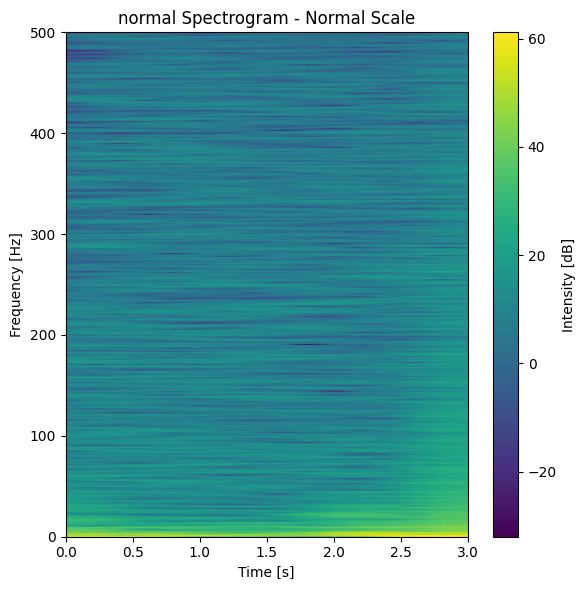

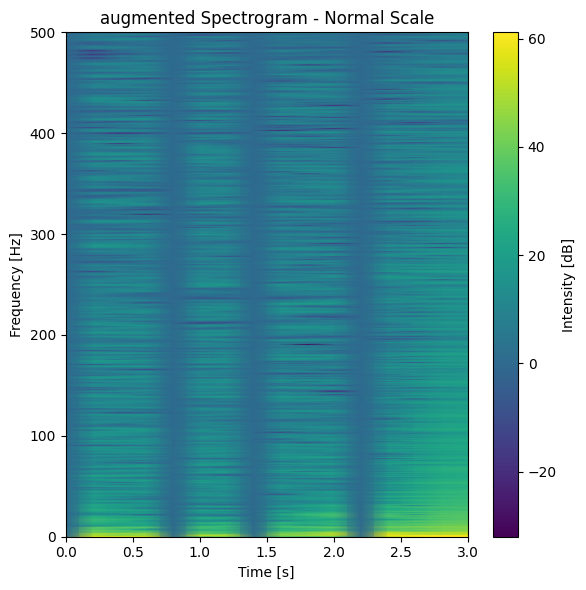

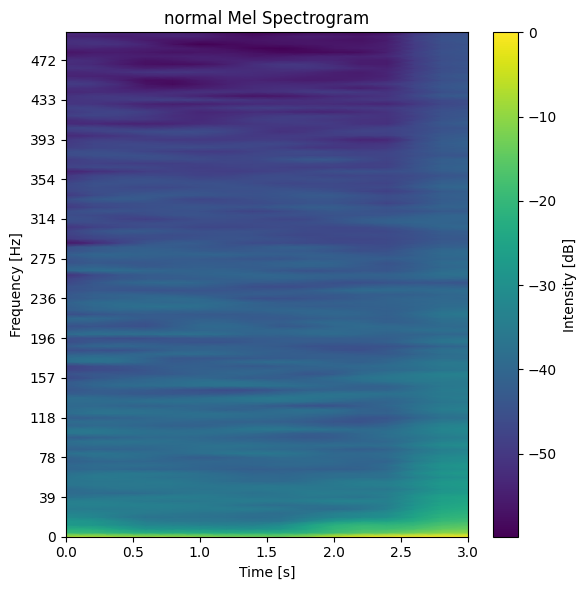

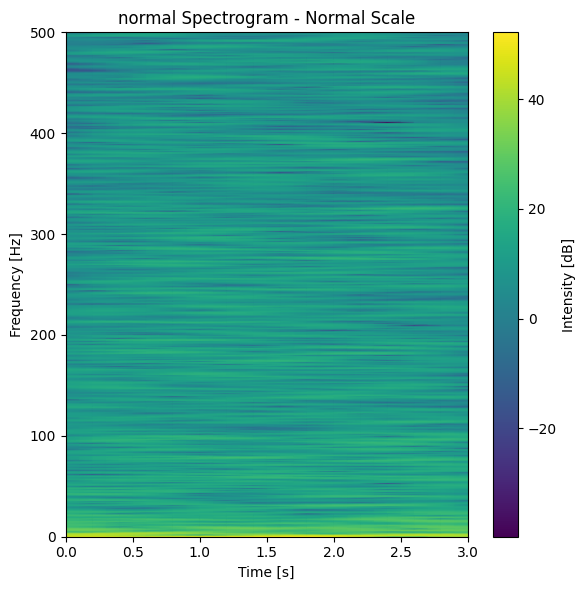

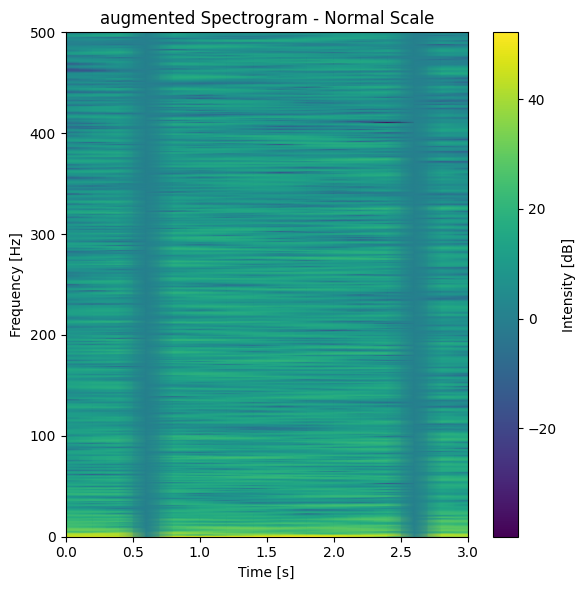

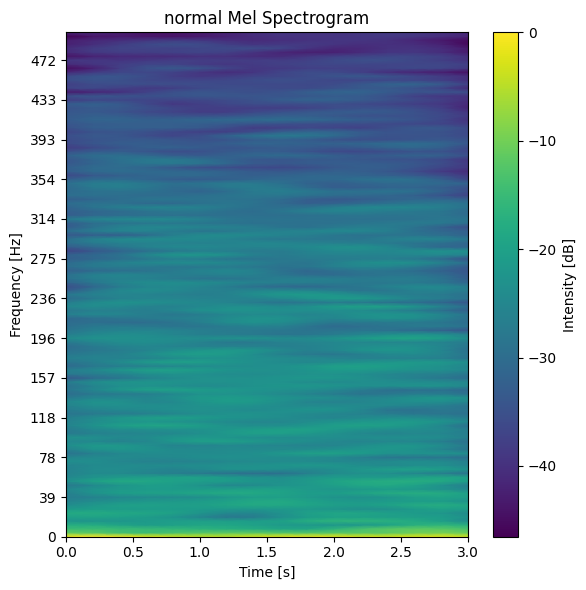

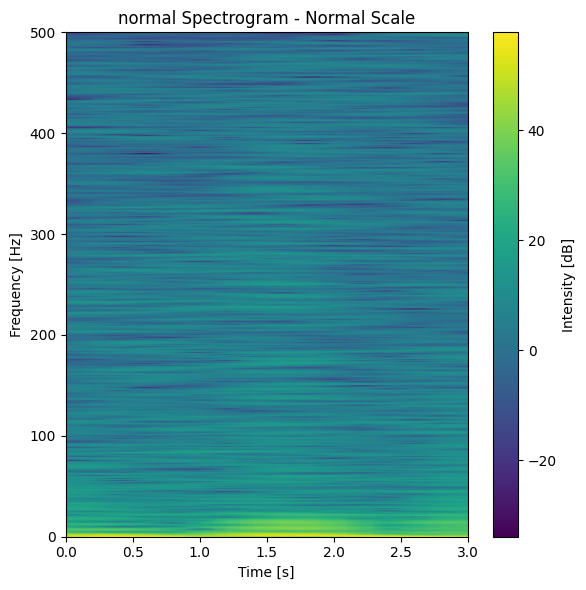

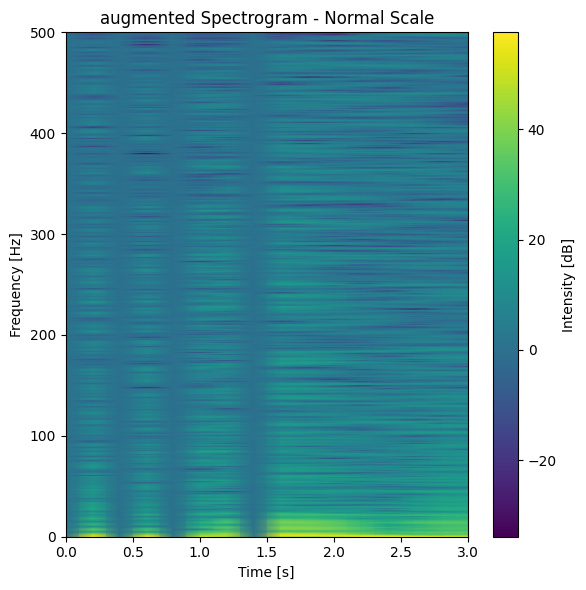

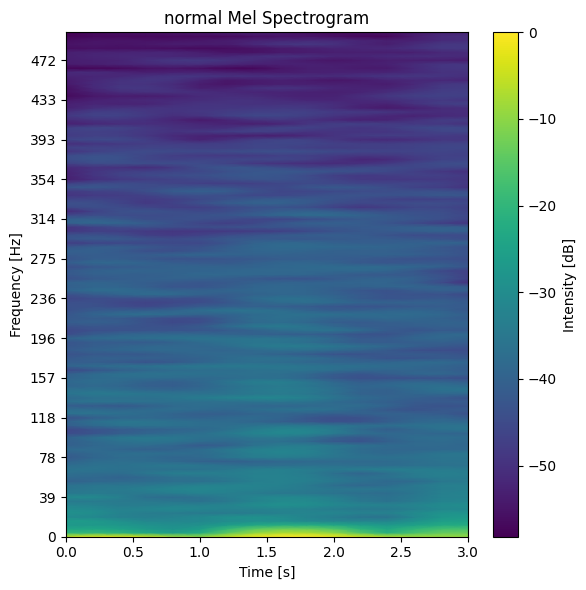

In [28]:
train_dataloader, val_dataloader, test_dataloader = build_multi_session_dataloader(channel_features_all,channel_labels_all,
                                                                                channel_trials_all, agg_channel_features_inflated_all,
                                                                                sessions, sweep_config, MultiModalDataset,test_session_idx=0)

In [29]:
train_dataloader.dataset[0][0][0].size()

torch.Size([8400])

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = train_dataloader.dataset[0][0][0].size()[0]
encoder = ContrastiveEncoder(sweep_config['fc_layer_size'], input_size=input_size, output_size=sweep_config['latent_size']).to(device)
model = ContrastiveLearningWithMLP(encoder, input_dim=sweep_config['latent_size'], hidden_dim=sweep_config['decoder_layer_size'], output_dim=5).to(device)

contrastive_criterion = InfoNCELoss(temperature=sweep_config['temperature'], device=device)
supervised_criterion = nn.CrossEntropyLoss()

encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=sweep_config["encoder_learning_rate"])
combined_optimizer = optim.Adam(model.parameters(), lr=sweep_config["decoder_learning_rate"])
best_decoder_loss = 10000
patience_counter = 0

In [31]:
for epoch in range(sweep_config["encoder_epochs"]):
    train_loss = train(model.encoder, train_dataloader, encoder_optimizer, contrastive_criterion, device)
    val_loss = validation(model.encoder, val_dataloader, contrastive_criterion, device)
    
    print(f'Epoch [{epoch+1}/{sweep_config["encoder_epochs"]}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/50], Train Loss: 3.5059, Val Loss: 3.4356
Epoch [2/50], Train Loss: 3.3948, Val Loss: 3.3800
Epoch [3/50], Train Loss: 3.3669, Val Loss: 3.3556
Epoch [4/50], Train Loss: 3.3433, Val Loss: 3.3388
Epoch [5/50], Train Loss: 3.3320, Val Loss: 3.3343
Epoch [6/50], Train Loss: 3.3255, Val Loss: 3.3313
Epoch [7/50], Train Loss: 3.3347, Val Loss: 3.3420
Epoch [8/50], Train Loss: 3.3309, Val Loss: 3.3301
Epoch [9/50], Train Loss: 3.3206, Val Loss: 3.3348
Epoch [10/50], Train Loss: 3.3268, Val Loss: 3.3325
Epoch [11/50], Train Loss: 3.3257, Val Loss: 3.3316
Epoch [12/50], Train Loss: 3.3190, Val Loss: 3.3290
Epoch [13/50], Train Loss: 3.3232, Val Loss: 3.3335
Epoch [14/50], Train Loss: 3.3220, Val Loss: 3.3308
Epoch [15/50], Train Loss: 3.3191, Val Loss: 3.3266
Epoch [16/50], Train Loss: 3.3156, Val Loss: 3.3258
Epoch [17/50], Train Loss: 3.3133, Val Loss: 3.3219
Epoch [18/50], Train Loss: 3.3109, Val Loss: 3.3210
Epoch [19/50], Train Loss: 3.3086, Val Loss: 3.3211
Epoch [20/50], Train 

In [33]:
for epoch in range(sweep_config['decoder_epochs']):
    decoder_train_metrics = train_decoder(model, train_dataloader, combined_optimizer, contrastive_criterion, supervised_criterion, mode=session_config['separate'], device=device)
    decoder_val_metrics = validate_decoder(model, val_dataloader, supervised_criterion, device=device)

    if decoder_val_metrics['loss'] < best_decoder_loss:
        best_decoder_loss, patience_counter = decoder_val_metrics['loss'], 0
    else:
        patience_counter += 1
        if patience_counter >= sweep_config['patience']: break

    print(f'Epoch [{epoch+1}/{sweep_config["decoder_epochs"]}], Train Loss: {decoder_train_metrics["loss"]:.4f}, Val Loss: {decoder_val_metrics["loss"]:.4f}, Train Acc: {decoder_train_metrics["balanced_accuracy"]:.4f}, Val Acc: {decoder_val_metrics["balanced_accuracy"]:.4f}')

Epoch [1/20], Train Loss: 4.1755, Val Loss: 0.7569, Train Acc: 0.4422, Val Acc: 0.4451
Epoch [2/20], Train Loss: 4.0511, Val Loss: 0.7287, Train Acc: 0.4589, Val Acc: 0.4759
Epoch [3/20], Train Loss: 4.0091, Val Loss: 0.6808, Train Acc: 0.4738, Val Acc: 0.4982
Epoch [4/20], Train Loss: 3.9453, Val Loss: 0.6303, Train Acc: 0.5104, Val Acc: 0.5165
Epoch [5/20], Train Loss: 3.8920, Val Loss: 0.6035, Train Acc: 0.5530, Val Acc: 0.5348
Epoch [6/20], Train Loss: 3.8517, Val Loss: 0.5811, Train Acc: 0.5809, Val Acc: 0.5986
Epoch [7/20], Train Loss: 3.8163, Val Loss: 0.5896, Train Acc: 0.6108, Val Acc: 0.6063
Epoch [8/20], Train Loss: 3.7834, Val Loss: 0.5671, Train Acc: 0.6418, Val Acc: 0.5916
Epoch [9/20], Train Loss: 3.7551, Val Loss: 0.5658, Train Acc: 0.6628, Val Acc: 0.5862
Epoch [10/20], Train Loss: 3.7209, Val Loss: 0.5450, Train Acc: 0.6855, Val Acc: 0.6531
Epoch [11/20], Train Loss: 3.6915, Val Loss: 0.5353, Train Acc: 0.7084, Val Acc: 0.6447
Epoch [12/20], Train Loss: 3.6606, Val Lo

In [34]:
decoder_test_metrics = validate_decoder(model, test_dataloader, supervised_criterion, device=device)
print(f"target session {sessions[0]} test balanced accuracy: ", decoder_test_metrics["balanced_accuracy"],
    f"target session {sessions[0]} test f1 score: ", decoder_test_metrics["macro_f1"])

target session AD_HF01_1 test balanced accuracy:  0.4502361572119636 target session AD_HF01_1 test f1 score:  0.39131399379601906
